Import the necessary libraries

In [12]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.ddpg.policies import MlpPolicy


Select the environment

In [13]:
env = gym.make("Pendulum-v1")

Configure DDPG

In [14]:
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

Select the model

In [15]:
model = DDPG(MlpPolicy, env, action_noise=action_noise, verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Train model

In [16]:
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

class RewardLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLoggerCallback, self).__init__(verbose)
        self.rewards = []
        self.cumulative_rewards = []

    def _on_step(self) -> bool:
        self.rewards.append(self.locals["rewards"])
        if self.locals["dones"]: 
            self.cumulative_rewards.append(np.sum(self.rewards))
            self.rewards = []  
        return True

reward_logger = RewardLoggerCallback()

trained_model = model.learn(total_timesteps=10000, callback=reward_logger)


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.54e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 62        |
|    time_elapsed    | 12        |
|    total_timesteps | 800       |
| train/             |           |
|    actor_loss      | 26.9      |
|    critic_loss     | 0.0407    |
|    learning_rate   | 0.001     |
|    n_updates       | 699       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.49e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 53        |
|    time_elapsed    | 29        |
|    total_timesteps | 1600      |
| train/             |           |
|    actor_loss      | 51.1      |
|    critic_loss     | 0.0705    |
|    learning_rate   | 0.001     |
|    n_updates      

Evaluate and test

In [17]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

Mean reward: -132.9480521 +/- 82.43835707415909


Plotting the learning curve

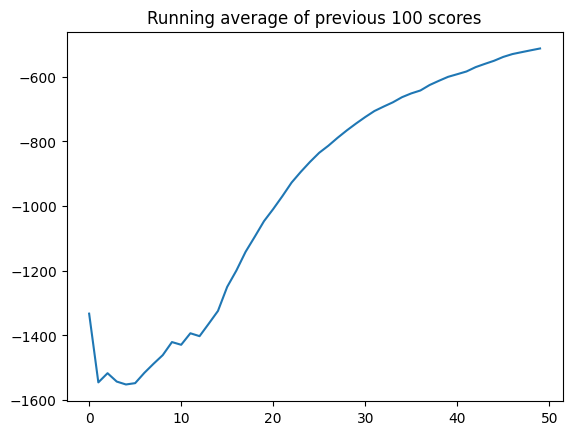

In [18]:
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

episode_rewards = reward_logger.cumulative_rewards
episodes = list(range(len(episode_rewards)))
plot_learning_curve(episodes, episode_rewards, 'ddpg_learning_curve.png')


In [19]:
model.save("DDPG_Pendulum")

Hyperparameter tuning

Learning rate: 0.001, Mean reward: -157.5497429
Learning rate: 0.01, Mean reward: -1593.2858776
Learning rate: 0.1, Mean reward: -1428.1994817


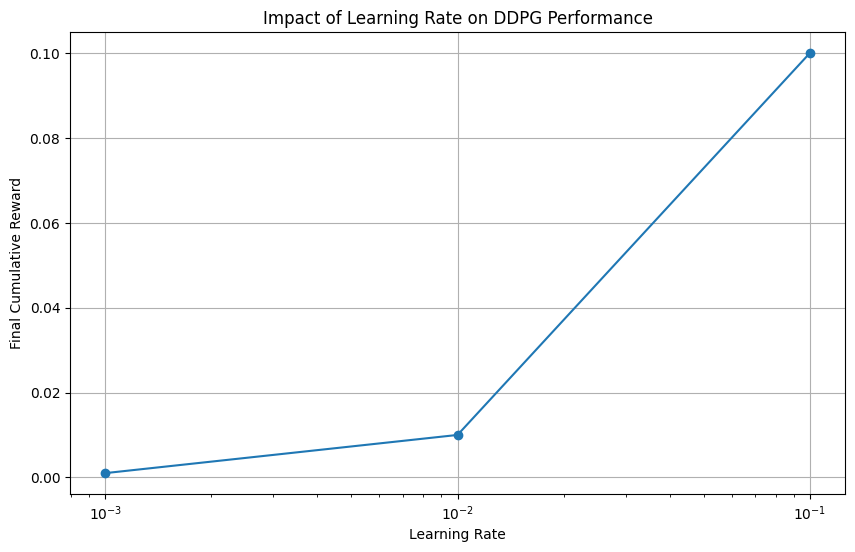

In [20]:
final_rewards = [] # replace this with actual rewards
learning_rates = [0.001, 0.01, 0.1]
for learning_rate in learning_rates:
    model = DDPG(MlpPolicy, env, action_noise=action_noise, learning_rate=learning_rate, verbose=0)
    model.learn(total_timesteps=10000)
    mean_reward, _ = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
    final_rewards.append(learning_rate)
    print(f"Learning rate: {learning_rate}, Mean reward: {mean_reward}")




plt.figure(figsize=(10, 6))
plt.plot(learning_rates, final_rewards, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Final Cumulative Reward')
plt.title('Impact of Learning Rate on DDPG Performance')
plt.xscale('log')
plt.grid(True)

plt.show()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.47e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 65        |
|    time_elapsed    | 12        |
|    total_timesteps | 800       |
| train/             |           |
|    actor_loss      | 24.8      |
|    critic_loss     | 0.0526    |
|    learning_rate   | 0.001     |
|    n_updates       | 699       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.47e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 57        |
|    time_elapsed    | 27        |
|    total_timesteps | 1600      |
| train/             |           |
|    actor_loss      | 47.3    

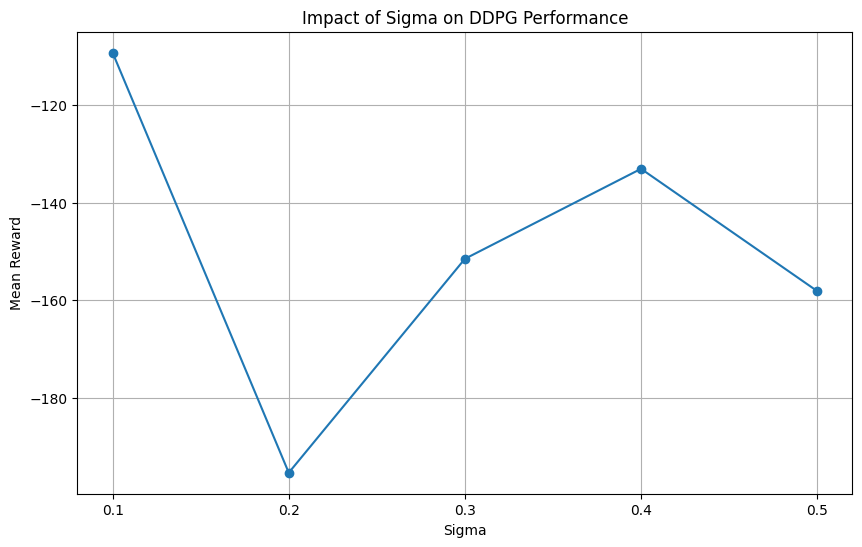

In [21]:
final_rewards = []

for sigma in [0.1, 0.2, 0.3, 0.4, 0.5]:
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=sigma * np.ones(n_actions))
    model = DDPG(MlpPolicy, env, action_noise=action_noise, verbose=1)
    model.learn(total_timesteps=10000)
    mean_reward, _ = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
    final_rewards.append(mean_reward)
    print(f"Sigma: {sigma}, Mean reward: {mean_reward}")

plt.figure(figsize=(10, 6))
plt.plot(final_rewards, marker='o')
plt.xlabel('Sigma')
plt.ylabel('Mean Reward')
plt.title('Impact of Sigma on DDPG Performance')
plt.xticks(range(len(final_rewards)), [0.1, 0.2, 0.3, 0.4, 0.5])
plt.grid(True)

plt.show()

## Buffer Size

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.45e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 66        |
|    time_elapsed    | 12        |
|    total_timesteps | 800       |
| train/             |           |
|    actor_loss      | 26.3      |
|    critic_loss     | 0.0167    |
|    learning_rate   | 0.001     |
|    n_updates       | 699       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.37e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 57        |
|    time_elapsed    | 27        |
|    total_timesteps | 1600      |
| train/             |           |
|    actor_loss      | 49.2    

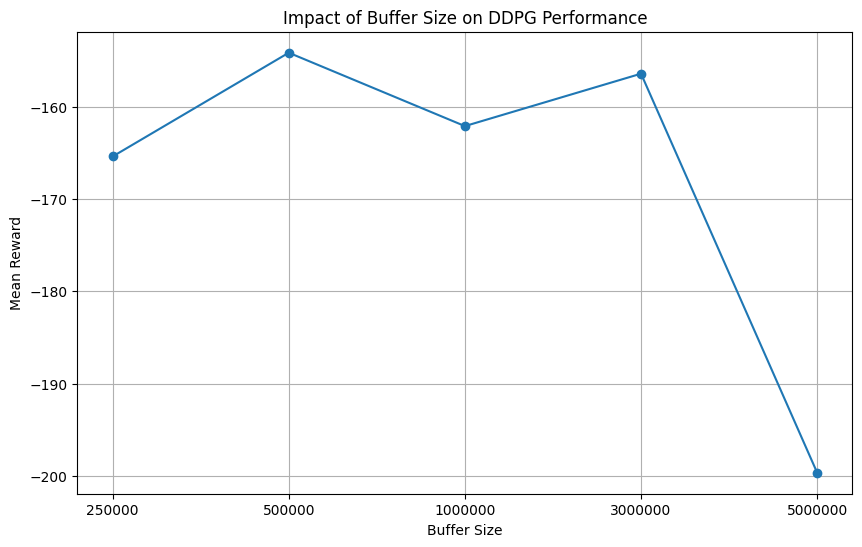

In [24]:
final_rewards = []

for buffer in [250000, 500000, 1000000, 3000000, 5000000]:
    model = DDPG(MlpPolicy, env, action_noise=action_noise, verbose=1, buffer_size=buffer)
    model.learn(total_timesteps=10000)
    mean_reward, _ = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
    final_rewards.append(mean_reward)
    print(f"Buffer size: {buffer}, Mean reward: {mean_reward}")

plt.figure(figsize=(10, 6))
plt.plot(final_rewards, marker='o')
plt.xlabel('Buffer Size')
plt.ylabel('Mean Reward')
plt.title('Impact of Buffer Size on DDPG Performance')
plt.xticks(range(len(final_rewards)), [250000, 500000, 1000000, 3000000, 5000000])

plt.grid(True)
plt.show()



## Batch Size

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.54e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 108       |
|    time_elapsed    | 7         |
|    total_timesteps | 800       |
| train/             |           |
|    actor_loss      | 27.9      |
|    critic_loss     | 0.105     |
|    learning_rate   | 0.001     |
|    n_updates       | 699       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.35e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 97        |
|    time_elapsed    | 16        |
|    total_timesteps | 1600      |
| train/             |           |
|    actor_loss      | 50.4    

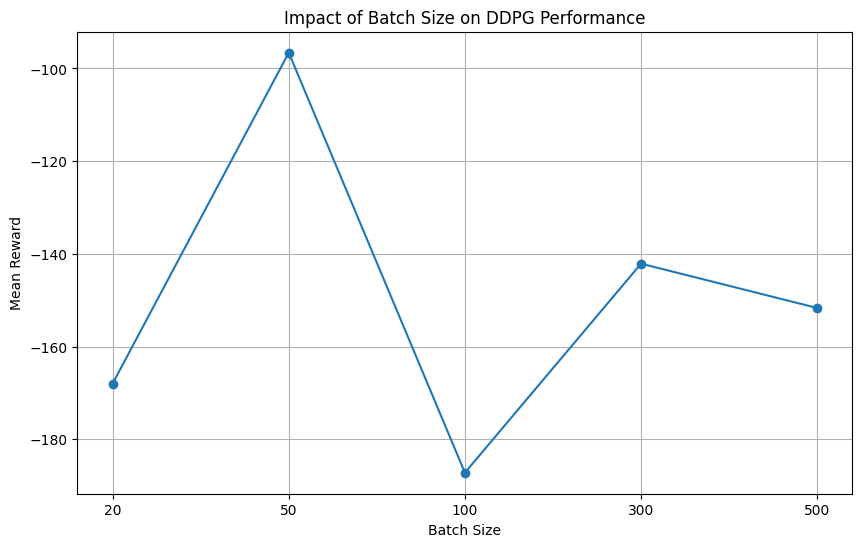

In [27]:
final_rewards = []

for batch in [20, 50, 100, 300, 500]:
    model = DDPG(MlpPolicy, env, action_noise=action_noise, verbose=1, batch_size=batch)
    model.learn(total_timesteps=10000)
    mean_reward, _ = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
    final_rewards.append(mean_reward)
    print(f"Batch size: {batch}, Mean reward: {mean_reward}")


plt.figure(figsize=(10, 6))
plt.plot(final_rewards, marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Mean Reward')
plt.title('Impact of Batch Size on DDPG Performance')
plt.xticks(range(len(final_rewards)), [20, 50, 100, 300, 500])

plt.grid(True)
plt.show()